In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_json("dataset.json")

# few rows of the dataframe
df.head()


,title,publication_date,author,content,source_url
0,"2023 Morocco Earthquake: Emergency Response, R...",2023-09-10,ReliefWeb,"This report covers the emergency response, rec...",https://reliefweb.int/report/morocco/2023-moro...
1,2023 Morocco Earthquake,2023-09-12,Center for Disaster Philanthropy,The 2023 Morocco earthquake caused significant...,https://disasterphilanthropy.org/disasters/202...
2,2023 Morocco Earthquake Disaster Brief,2023-09-15,ReliefWeb,This disaster brief provides an overview of th...,https://reliefweb.int/report/morocco/2023-moro...
3,Economic Impacts of the 2023 Earthquake in Mor...,2023-10-01,Policy Center for the New South,This publication discusses the economic impact...,https://www.policycenter.ma/sites/default/file...
4,Morocco Earthquake: IFRC and Moroccan Red Cres...,2023-09-18,IFRC,The IFRC and Moroccan Red Crescent have been a...,https://www.ifrc.org/article/morocco-earthquak...


In [2]:
df = pd.read_json("dataset.json", orient='records')
print(df.head())


                                               title publication_date  \
0  2023 Morocco Earthquake: Emergency Response, R...       2023-09-10   
1                            2023 Morocco Earthquake       2023-09-12   
2             2023 Morocco Earthquake Disaster Brief       2023-09-15   
3  Economic Impacts of the 2023 Earthquake in Mor...       2023-10-01   
4  Morocco Earthquake: IFRC and Moroccan Red Cres...       2023-09-18   

                             author  \
0                         ReliefWeb   
1  Center for Disaster Philanthropy   
2                         ReliefWeb   
3   Policy Center for the New South   
4                              IFRC   

                                             content  \
0  This report covers the emergency response, rec...   
1  The 2023 Morocco earthquake caused significant...   
2  This disaster brief provides an overview of th...   
3  This publication discusses the economic impact...   
4  The IFRC and Moroccan Red Crescent have bee

In [3]:
# Calcul des corrélations entre les termes
import pandas as pd
df = pd.read_json("dataset.json")
# Sélectionner uniquement les colonnes numériques
df_numeric = df.select_dtypes(include=[float, int])

# Calculer la corrélation sur les colonnes numériques
correlation_matrix = df_numeric.corr()

# Afficher les corrélations
print(correlation_matrix)


Empty DataFrame
Columns: []
Index: []


In [4]:
# Remove leading and trailing spaces
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.info()

# Remove rows with missing values
df = df.dropna()

# Convert publication_date to datetime
df['publication_date'] = pd.to_datetime(df['publication_date'])

# Sort by publication_date
df = df.sort_values(by='publication_date', ascending=False)

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             39 non-null     object
 1   publication_date  39 non-null     object
 2   author            39 non-null     object
 3   content           39 non-null     object
 4   source_url        39 non-null     object
dtypes: object(5)
memory usage: 1.6+ KB


,title,publication_date,author,content,source_url
14,Séisme au Maroc - Panique et dégâts matériels,2024-08-21,Le Matin,This report covers the panic and material dama...,https://lematin.ma/express/2023/seisme-maroc-p...
13,Séisme au Maroc - Retour sur une catastrophe n...,2024-08-21,Le Matin,This article reflects on the natural disaster ...,https://lematin.ma/express/2023/seisme-maroc-r...
17,Séisme au Maroc - L'activité sismique a grimpé...,2024-01-03,Hespress,This report discusses the increase in seismic ...,https://fr.hespress.com/329915-seisme-au-maroc...
19,Reconstruction post-séisme - Le Maroc prouve s...,2023-10-12,Hespress,This article highlights Morocco's resilience a...,https://fr.hespress.com/334400-reconstruction-...
12,Séisme du Haut Atlas - Émission spéciale à ne ...,2023-10-03,2M,This special program focuses on the High Atlas...,https://2m.ma/fr/news/Grand-Angle-Une-%C3%A9mi...


In [5]:
# Group by source URL and count the number of articles per source
df_grouped_by_source = df.groupby('source_url').size().reset_index(name='count')

# Group by author and count the number of articles per author
df_grouped_by_author = df.groupby('author').size().reset_index(name='count')

df_grouped_by_source.head(), df_grouped_by_author.head()


(                                          source_url  count
 0  https://2m.ma/fr/news/Grand-Angle-Une-%C3%A9mi...      1
 1  https://2m.ma/fr/news/S%C3%A9isme-Le-Maroc-a-e...      1
 2  https://2m.ma/fr/news/S%C3%A9isme-d-Al-Haouz-E...      1
 3  https://disasterphilanthropy.org/disasters/202...      1
 4  https://fr.hespress.com/329664-fort-tremblemen...      1,
                              author  count
 0                                2M      3
 1                  BBC NEWS AFRIQUE      2
 2  Center for Disaster Philanthropy      1
 3                              EBRD      1
 4                         France 24      4)

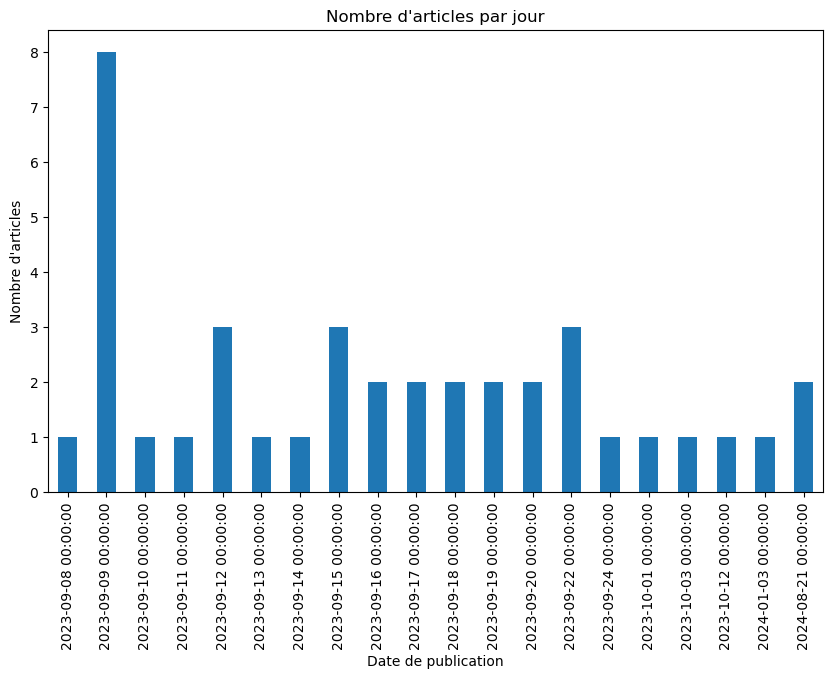

In [6]:
# Plot number of articles per day
plt.figure(figsize=(10, 6))
df['publication_date'].value_counts().sort_index().plot(kind='bar')
plt.title('Nombre d\'articles par jour')
plt.xlabel('Date de publication')
plt.ylabel('Nombre d\'articles')
plt.xticks(rotation=90)
plt.show()


In [7]:
# Find peak dates with the highest number of articles
peak_dates = df['publication_date'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Display the peak dates
peak_dates.head()


,index,count
0,2023-09-09,8
2,2023-09-15,3
3,2023-09-22,3
1,2023-09-12,3
4,2024-08-21,2


<Figure size 1000x600 with 0 Axes>

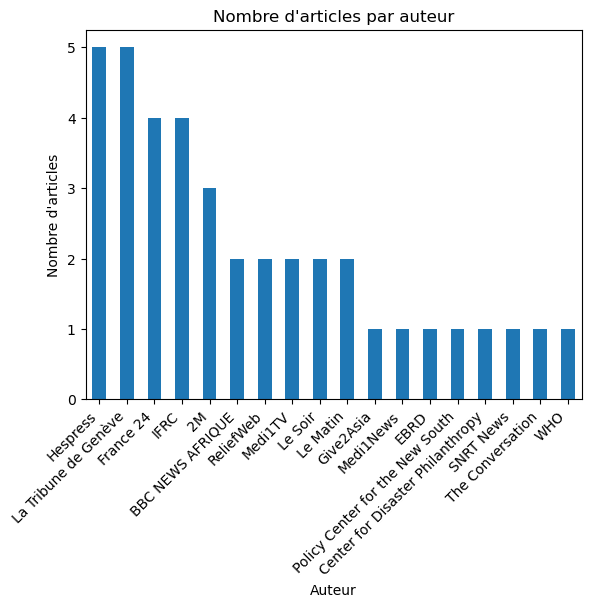

In [8]:
# Plot the number of articles per author
plt.figure(figsize=(10, 6))
df_grouped_by_author.sort_values(by='count', ascending=False).plot(kind='bar', x='author', y='count', legend=False)
plt.title('Nombre d\'articles par auteur')
plt.xlabel('Auteur')
plt.ylabel('Nombre d\'articles')
plt.xticks(rotation=45, ha='right')
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Purple\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


earthquake        25
morocco           22
article           14
report             8
covers             7
following          7
2023               7
efforts            7
inondations        6
discusses          4
libye              4
response           4
recovery           4
various            4
reconstruction     3
highlights         3
reports            3
provides           3
cities             3
impact             3
dtype: int64


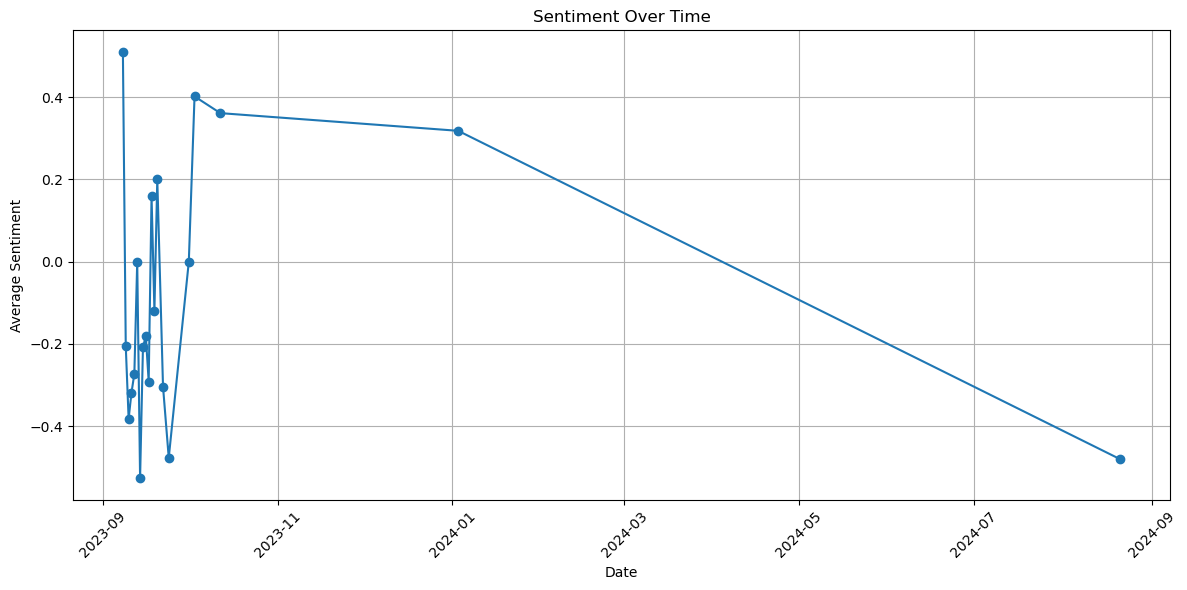

In [9]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from stop_words import get_stop_words
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the necessary NLTK data files 
nltk.download('vader_lexicon')

# Combine English and French stopwords
french_stopwords = get_stop_words('fr')
combined_stopwords = list(ENGLISH_STOP_WORDS) + french_stopwords

# Basic text cleaning
df['content'] = df['content'].apply(lambda x: re.sub(r'\W+', ' ', x.lower()))

# Word frequency count with combined stopwords
vectorizer = CountVectorizer(stop_words=combined_stopwords)
word_counts = vectorizer.fit_transform(df['content'])

# Get top words
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
word_counts_sum = word_counts_df.sum().sort_values(ascending=False)

# Show top words
print(word_counts_sum.head(20))

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Convert 'publication_date' to datetime 
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')

# Group by 'publication_date' and calculate average sentiment
sentiment_summary = df.groupby('publication_date')['sentiment'].mean().reset_index()

# Plot sentiment over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_summary['publication_date'], sentiment_summary['sentiment'], marker='o')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load BERT tokenizer and pre-trained model for sentiment analysis
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming binary sentiment classification

# Tokenization and conversion to tensors
tokens = tokenizer.batch_encode_plus(df['content'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Perform sentiment analysis
with torch.no_grad():
    outputs = model(**tokens)

# Get predictions (logits) and convert to sentiment labels
predictions = torch.argmax(outputs.logits, dim=1)
print(predictions)


# Sentiment analysis would involve further steps like passing the tokens through the model and applying some classifier.
# Here we leave it as a placeholder for more advanced analysis.


C:\Users\Purple\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


     Topic     Word 1       Word 2       Word 3     Word 4       Word 5  \
0  Topic 1   disaster         toll        death    initial     provides   
1  Topic 2     caused       cities  intempéries     brienz      morocco   
2  Topic 3  discusses        haouz           al       high    aftermath   
3  Topic 4   response  earthquakes      impacts  discusses  catastrophe   
4  Topic 5   recovery       impact         2023     report      various   

      Word 6      Word 7       Word 8       Word 9     Word 10  
0  following      report      article   earthquake     morocco  
1    article  resilience        libye  inondations  earthquake  
2      atlas   following       covers      article  earthquake  
3    article        2023  inondations   earthquake     morocco  
4    article      covers      efforts      morocco  earthquake  


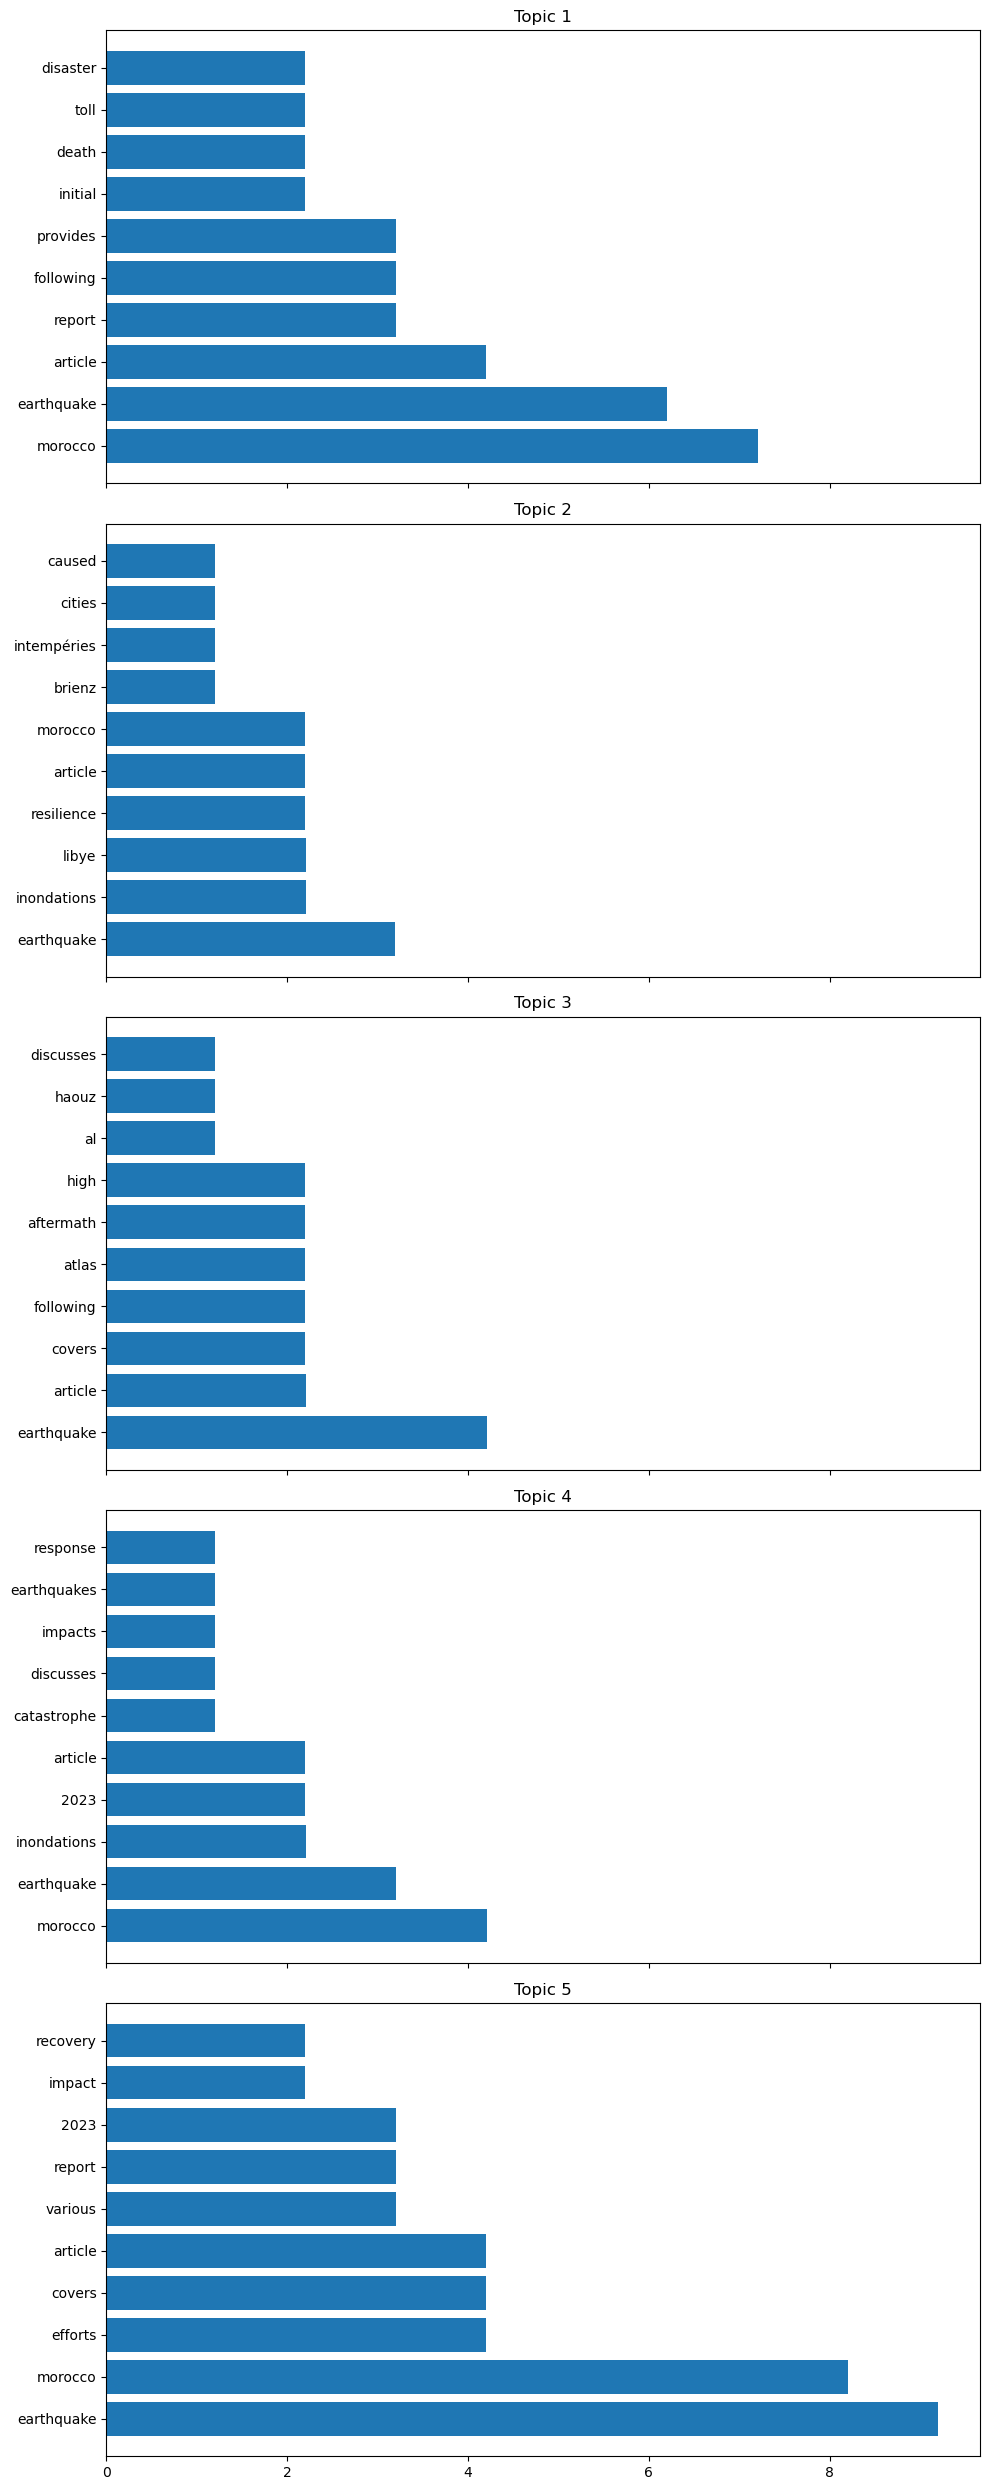

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from stop_words import get_stop_words

# Combine English and French stopwords
french_stopwords = get_stop_words('fr')
combined_stopwords = list(ENGLISH_STOP_WORDS) + french_stopwords

# Use the cleaned DataFrame 'df' with stopwords removed
# Create the Document-Term Matrix (DTM) using the cleaned content
vectorizer = CountVectorizer(stop_words=combined_stopwords)
dtm = vectorizer.fit_transform(df['content'])

# Fit the LDA model with a specified number of topics
num_topics = 5  
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Extract the top 10 words per topic
feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = {}
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = np.argsort(topic)[-10:]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_indices]
    top_words_per_topic[f"Topic {topic_idx + 1}"] = top_words

# Convert to DataFrame for easy manipulation
top_words_df = pd.DataFrame.from_dict(top_words_per_topic, orient='index').reset_index()
top_words_df.columns = ['Topic'] + [f'Word {i+1}' for i in range(top_words_df.shape[1] - 1)]

# Display the top 10 words per topic
print(top_words_df)

# Visualize the top 10 words per topic
fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(10, 5 * num_topics), sharex=True)
for i, (topic, words) in enumerate(top_words_per_topic.items()):
    axes[i].barh(words, lda_model.components_[i, np.argsort(lda_model.components_[i])[-10:]])
    axes[i].set_title(topic)
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()


<span style="font-size: 40px;">BERT</span>

In [12]:
import re
import nltk
from nltk.tokenize import sent_tokenize
from transformers import BertTokenizer, BertForSequenceClassification
import torch

nltk.download('punkt')

# Define keywords for each category with more variations
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def categorize_sentences(content, keywords):
    sentences = sent_tokenize(content)  # Use NLTK's sentence tokenizer
    categorized_sentences = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return categorized_sentences

# Load BERT model 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Adjust num_labels as needed

def extract_critical_information(text):
    # Extract sentences based on keywords
    impact_sentences = categorize_sentences(text, impact_keywords)
    response_sentences = categorize_sentences(text, response_keywords)
    recovery_sentences = categorize_sentences(text, recovery_keywords)
    
    return impact_sentences, response_sentences, recovery_sentences

# Process each article
for index, row in df.iterrows():
    content = row['content']
    
    # Extract sentences for each category
    impact_sentences, response_sentences, recovery_sentences = extract_critical_information(content)
    
    # Save categorized sentences to files
    with open('impact_sentences.txt', 'a') as file:
        file.write('\n'.join(impact_sentences) + '\n')
    
    with open('response_sentences.txt', 'a') as file:
        file.write('\n'.join(response_sentences) + '\n')
    
    with open('recovery_sentences.txt', 'a') as file:
        file.write('\n'.join(recovery_sentences) + '\n')

print("Categorization complete. Check 'impact_sentences.txt', 'response_sentences.txt', and 'recovery_sentences.txt' for results.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Purple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Purple\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Categorization complete. Check 'impact_sentences.txt', 'response_sentences.txt', and 'recovery_sentences.txt' for results.


In [13]:
# Define a function to read and display file contents
def display_file_content(filename):
    with open(filename, 'r') as file:
        content = file.read()
    print(f"Contents of {filename}:")
    print(content[:1000])  # Print the first 1000 characters 
# Display the contents of each file
display_file_content('impact_sentences.txt')
display_file_content('response_sentences.txt')
display_file_content('recovery_sentences.txt')


Contents of impact_sentences.txt:
this report covers the panic and material damage caused by the earthquake in various moroccan cities
this article reflects on the natural disaster and its significant impacts across morocco



this publication discusses the economic impacts of the 2023 earthquake in morocco and the subsequent recovery efforts















this disaster brief provides an overview of the impact and initial response to the 2023 morocco earthquake





the 2023 morocco earthquake caused significant damage and resulted in a coordinated response from various organizations



the article reports on a 6 8 magnitude earthquake in morocco highlighting the widespread panic destruction and over 600 deaths with personal accounts from those affected it also covers the ongoing rescue efforts and the emotional impact on survivors
this report covers the severe impact of the earthquake on various regions of morocco






this report covers the panic and material damage caused by the e

In [14]:
# Save cleaned data and results
df.to_csv("cleaned_dataset.csv", index=False)
peak_dates.to_csv("peak_dates.csv", index=False)
df_grouped_by_author.to_csv("author_counts.csv", index=False)
word_counts_sum.to_csv("word_counts.csv", index=False)


<span style="font-size: 40px;">BART</span>

In [15]:
import re
import nltk
from nltk.tokenize import sent_tokenize
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

# Ensure nltk resources are available
nltk.download('punkt')

# Define keywords for each category
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Load BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

# Function to categorize sentences based on keywords
def categorize_sentences(content, keywords):
    sentences = sent_tokenize(content)  # Use NLTK's sentence tokenizer
    categorized_sentences = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return categorized_sentences

# Function to refine sentences using BART as a rephrasing model
def rephrase_sentences(sentences):
    rephrased_sentences = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(
            inputs['input_ids'], 
            num_beams=4, 
            max_length=len(sentence.split()) + 20,  # Setting max_length relative to the input length
            min_length=len(sentence.split()) - 5,   # Ensuring it doesn't shorten excessively
            early_stopping=True,
            do_sample=False,  # Avoiding sampling to keep output closer to original
            length_penalty=2.0  # Encouraging longer outputs
        )
        rephrased_sentence = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        rephrased_sentences.append(rephrased_sentence)
    return rephrased_sentences

def extract_and_refine_information(text):
    # Extract sentences based on keywords
    impact_sentences = categorize_sentences(text, impact_keywords)
    response_sentences = categorize_sentences(text, response_keywords)
    recovery_sentences = categorize_sentences(text, recovery_keywords)
    
    # Rephrase the extracted sentences using BART
    refined_impact = rephrase_sentences(impact_sentences)
    refined_response = rephrase_sentences(response_sentences)
    refined_recovery = rephrase_sentences(recovery_sentences)
    
    return refined_impact, refined_response, refined_recovery

# Process each article in the dataset (assuming df is your DataFrame containing articles)
for index, row in df.iterrows():
    content = row['content']
    
    # Extract and refine sentences for each category
    refined_impact, refined_response, refined_recovery = extract_and_refine_information(content)
    
    # Save categorized sentences to files
    with open('refined_impact_sentences.txt', 'a') as file:
        file.write('\n'.join(refined_impact) + '\n')
    
    with open('refined_response_sentences.txt', 'a') as file:
        file.write('\n'.join(refined_response) + '\n')
    
    with open('refined_recovery_sentences.txt', 'a') as file:
        file.write('\n'.join(refined_recovery) + '\n')

print("Extraction and rephrasing complete. Check 'refined_impact_sentences.txt', 'refined_response_sentences.txt', and 'refined_recovery_sentences.txt' for results.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Purple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Purple\anaconda3\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control 

Extraction and rephrasing complete. Check 'refined_impact_sentences.txt', 'refined_response_sentences.txt', and 'refined_recovery_sentences.txt' for results.


<span style="font-size: 40px;">GPT-2</span>

In [16]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import nltk
from nltk.tokenize import sent_tokenize

# Load dataset
df = pd.read_json("dataset.json")

# Remove leading/trailing spaces and drop missing values
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x).dropna()

nltk.download('punkt')

# Define keywords for each category
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def categorize_sentences(content, keywords):
    sentences = sent_tokenize(content)
    categorized_sentences = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return categorized_sentences

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Ensure the pad token is set 
tokenizer.pad_token = tokenizer.eos_token

# Prepare text data for tokenization
texts = df['content'].tolist()  # Assuming 'content' is the column with the text data

# Tokenize the text
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

# Clone the input_ids for labels
labels = inputs['input_ids'].clone()

# Prepare the dataset for training
train_dataset = Dataset.from_dict({
    'input_ids': inputs['input_ids'].tolist(),
    'attention_mask': inputs['attention_mask'].tolist(),
    'labels': labels.tolist()  # Labels must match input_ids shape
})

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_dir='./logs',
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()

# Define a function to generate text based on a keyword category
def generate_text(keyword_category, input_text):
    inputs = tokenizer(f"summarize: {keyword_category} {input_text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs.input_ids, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Process each article to classify/summarize text based on categories
for index, row in df.iterrows():
    content = row['content']
    
    # Categorize and summarize sentences for each category
    impact_sentences = categorize_sentences(content, impact_keywords)
    response_sentences = categorize_sentences(content, response_keywords)
    recovery_sentences = categorize_sentences(content, recovery_keywords)
    
    # Generate summaries for each category
    impact_summary = generate_text("impact", ' '.join(impact_sentences)) if impact_sentences else "No impact-related content"
    response_summary = generate_text("response", ' '.join(response_sentences)) if response_sentences else "No response-related content"
    recovery_summary = generate_text("recovery", ' '.join(recovery_sentences)) if recovery_sentences else "No recovery-related content"
    
    # Save summarized content to files
    with open('impact_summaries_gpt2.txt', 'a') as file:
        file.write(impact_summary + '\n')
    
    with open('response_summaries_gpt2.txt', 'a') as file:
        file.write(response_summary + '\n')
    
    with open('recovery_summaries_gpt2.txt', 'a') as file:
        file.write(recovery_summary + '\n')

print("Summarization and classification complete. Check 'impact_summaries_gpt2.txt', 'response_summaries_gpt2.txt', and 'recovery_summaries_gpt2.txt' for results.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Purple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Purple\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Purple\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 39
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15
 

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain 

Summarization and classification complete. Check 'impact_summaries_gpt2.txt', 'response_summaries_gpt2.txt', and 'recovery_summaries_gpt2.txt' for results.


In [17]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from rouge import Rouge
from datasets import load_metric

# Load dataset
df = pd.read_json("dataset.json")

# Preprocessing
df['content'] = df['content'].apply(lambda x: str(x).strip())
df = df.dropna(subset=['content'])

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['content'], df['category'], test_size=0.2, random_state=42
)

# Initialize BERT model for text classification
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Modify num_labels as per your categories

# Tokenize text data for BERT
train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
test_encodings = bert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# Prepare PyTorch datasets
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels.tolist())
test_dataset = TextDataset(test_encodings, test_labels.tolist())

# Train the BERT classifier
training_args = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_args = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model.to(device)

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=5e-5)

# Training loop
bert_model.train()
for epoch in range(3):  # Train for 3 epochs
    for batch in training_args:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = bert_model(**inputs, labels=batch['labels'].to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate BERT classifier
bert_model.eval()
preds = []
with torch.no_grad():
    for batch in test_args:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = bert_model(**inputs)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Classification metrics
print("Accuracy:", accuracy_score(test_labels, preds))
print("F1 Score:", f1_score(test_labels, preds, average='weighted'))
print(classification_report(test_labels, preds))

# Confusion matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BERT Classification')
plt.show()

# Named Entity Recognition (NER)
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", tokenizer=bert_tokenizer)
example_text = test_texts.iloc[0]
ner_results = ner_pipeline(example_text)
print("NER Results:", ner_results)

# Summarization with T5
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')

# Unified Pipeline: BERT first, then T5 for summarization
for i, text in enumerate(test_texts[:3]):  # Summarize first 3 test texts
    # Get category from BERT
    inputs = bert_tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = bert_model(**inputs)
    predicted_category = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    
    # Use T5 to summarize
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    print(f"Text {i+1} - Predicted Category: {predicted_category}")
    print(f"Summary {i+1}: {summary}")

# Summarization metrics: ROUGE & BLEU
rouge = Rouge()
bleu_metric = load_metric("bleu")

hypotheses = [t5_tokenizer.decode(t5_model.generate(t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt"))[0]) for text in test_texts[:10]]
references = test_texts[:10].tolist()

rouge_scores = rouge.get_scores(hypotheses, references, avg=True)
bleu_scores = bleu_metric.compute(predictions=hypotheses, references=[[ref] for ref in references])

print("ROUGE Scores:", rouge_scores)
print("BLEU Scores:", bleu_scores)

# Visualize ROUGE Scores
plt.figure(figsize=(10,5))
plt.bar(rouge_scores.keys(), [v['f'] for v in rouge_scores.values()])
plt.title("ROUGE Scores for Summarization")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()

# Word Clouds for categories
for category in df['category'].unique():
    text = ' '.join(df[df['category'] == category]['content'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Category: {category}")
    plt.show()

# Frequency Distribution Visualization
category_counts = df['category'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Frequency Distribution of Categories')
plt.ylabel('Count')
plt.xlabel('Category')
plt.show()


ImportError: cannot import name 'load_metric' from 'datasets' (C:\Users\Purple\anaconda3\lib\site-packages\datasets\__init__.py)

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import torch
from transformers import BertTokenizer, BertForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu

nltk.download('punkt')  # For sentence tokenization

# Load dataset
df = pd.read_json("dataset.json")

# Define keywords for each category with more variations
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def categorize_sentences(content, keywords):
    sentences = sent_tokenize(content)  # Use NLTK's sentence tokenizer
    categorized_sentences = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return ' '.join(categorized_sentences)  # Return joined sentences for easier handling

# Function to assign categories based on keywords
def assign_category(content):
    if any(keyword in content.lower() for keyword in impact_keywords):
        return 'Impact'
    elif any(keyword in content.lower() for keyword in response_keywords):
        return 'Response'
    elif any(keyword in content.lower() for keyword in recovery_keywords):
        return 'Recovery'
    else:
        return 'Other'  # Default category if no keywords match

# Apply categorization to the DataFrame
df['category'] = df['content'].apply(assign_category)

# Preprocessing
df['content'] = df['content'].apply(lambda x: str(x).strip())
df = df.dropna(subset=['content'])

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['content'], df['category'], test_size=0.2, random_state=42
)

# Initialize BERT model for text classification
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category'].unique()))  # Adjust num_labels based on your categories

# Tokenize text data for BERT
train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
test_encodings = bert_tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# Prepare PyTorch datasets
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure the labels are of dtype long
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels.tolist())
test_dataset = TextDataset(test_encodings, test_labels.tolist())

# Train the BERT classifier
training_args = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_args = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
bert_model.to(device)

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=5e-5)

# Training loop
bert_model.train()
for epoch in range(3):  # Train for 3 epochs
    for batch in training_args:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = bert_model(**inputs, labels=batch['labels'].to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate BERT classifier
bert_model.eval()
preds = []
with torch.no_grad():
    for batch in test_args:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = bert_model(**inputs)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

# Classification metrics
print("Accuracy:", accuracy_score(test_labels, preds))
print("F1 Score:", f1_score(test_labels, preds, average='weighted'))
print(classification_report(test_labels, preds))

# Confusion matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BERT Classification')
plt.show()

# Named Entity Recognition (NER)
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", tokenizer=bert_tokenizer)
example_text = test_texts.iloc[0]
ner_results = ner_pipeline(example_text)
print("NER Results:", ner_results)

# Summarization with T5
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')

# Unified Pipeline: BERT first, then T5 for summarization
hypotheses = []
for i, text in enumerate(test_texts[:3]):  # Summarize first 3 test texts
    # Get category from BERT
    inputs = bert_tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = bert_model(**inputs)
    predicted_category = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    
    # Use T5 to summarize
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    print(f"Text {i+1} - Predicted Category: {predicted_category}")
    print(f"Summary {i+1}: {summary}")
    hypotheses.append(summary)

# Summarization metrics: ROUGE & BLEU
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Hypotheses and references for ROUGE and BLEU
references = [text for text in test_texts[:10]]
hypotheses = [t5_tokenizer.decode(t5_model.generate(t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt"))[0], skip_special_tokens=True) for text in test_texts[:10]]

# Compute ROUGE scores
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
for i in range(len(hypotheses)):
    scores = rouge_scorer.score(references[i], hypotheses[i])
    for key in rouge_scores.keys():
        rouge_scores[key] += scores[key].fmeasure
rouge_scores = {key: value / len(hypotheses) for key, value in rouge_scores.items()}
print("ROUGE Scores:", rouge_scores)

# Compute BLEU scores
references_bleu = [[nltk.word_tokenize(ref)] for ref in references]
hypotheses_bleu = [nltk.word_tokenize(hyp) for hyp in hypotheses]
bleu_score = corpus_bleu(references_bleu, hypotheses_bleu)
print("BLEU Score:", bleu_score)

# Visualize ROUGE Scores
plt.figure(figsize=(10,5))
plt.bar(rouge_scores.keys(), [v for v in rouge_scores.values()])
plt.title("ROUGE Scores for Summarization")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()

# Word Clouds for categories
for category in df['category'].unique():
    text = ' '.join(df[df['category'] == category]['content'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Category: {category}")
    plt.show()

# Frequency Distribution Visualization
category_counts = df['category'].value_counts()
plt.figure(figsize=(10, 7))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.show()


In [ ]:
import evaluate

# Use evaluate for ROUGE and BLEU
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")



In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate  # Replace datasets with evaluate

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load BERT model for classification and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 labels: Impact, Response, Recovery

# Load T5 model for summarization and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define categories for classification
categories = {0: "Impact", 1: "Response", 2: "Recovery"}

# Load ROUGE and BLEU metrics for summarization evaluation
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

# Function to classify text using BERT
def classify_text(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    label = outputs.logits.argmax(dim=1).item()
    return label

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Classify the content
    label = classify_text(content)
    category = categories[label]
    
    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact":
        impact_texts.append(content)
    elif category == "Response":
        response_texts.append(content)
    else:
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Generate word clouds for each category
def generate_wordcloud(texts, title):
    text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Confusion matrix (assuming manually assigned labels for evaluation)
# You would replace 'true_labels' with the actual manually assigned categories
true_labels = [0] * len(impact_texts) + [1] * len(response_texts) + [2] * len(recovery_texts)
pred_labels = [classify_text(text) for text in df['content']]

# Confusion Matrix and Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Impact", "Response", "Recovery"], yticklabels=["Impact", "Response", "Recovery"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# ROUGE Score
rouge_scores = rouge.compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)

# BLEU Score (using a simplified format)
bleu_scores = bleu.compute(predictions=[s.split() for s in summaries], references=[[ref.split()] for ref in references])
print("BLEU Score:", bleu_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate  # Replace datasets with evaluate

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load BERT model for classification and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 labels: Impact, Response, Recovery

# Load T5 model for summarization and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define categories for classification
categories = {0: "Impact", 1: "Response", 2: "Recovery"}

# Load ROUGE and BLEU metrics for summarization evaluation
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

# Function to classify text using BERT
def classify_text(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    label = outputs.logits.argmax(dim=1).item()
    return label

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Classify the content
    label = classify_text(content)
    category = categories[label]
    
    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact":
        impact_texts.append(content)
    elif category == "Response":
        response_texts.append(content)
    else:
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Generate word clouds for each category if they are not empty
def generate_wordcloud(texts, title):
    if len(texts) > 0:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print(f"No data available for {title}")

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Confusion matrix (assuming manually assigned labels for evaluation)
# You would replace 'true_labels' with the actual manually assigned categories
true_labels = [0] * len(impact_texts) + [1] * len(response_texts) + [2] * len(recovery_texts)
pred_labels = [classify_text(text) for text in df['content']]

# Confusion Matrix and Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Impact", "Response", "Recovery"], yticklabels=["Impact", "Response", "Recovery"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# ROUGE Score
rouge_scores = rouge.compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)

# BLEU Score (using a simplified format)
bleu_scores = bleu.compute(predictions=[s.split() for s in summaries], references=[[ref.split()] for ref in references])
print("BLEU Score:", bleu_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate  # Use evaluate for ROUGE and BLEU metrics

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load BERT model for classification and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 labels: Impact, Response, Recovery

# Load T5 model for summarization and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define categories for classification
categories = {0: "Impact", 1: "Response", 2: "Recovery"}

# Load ROUGE and BLEU metrics for summarization evaluation
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

# Function to classify text using BERT
def classify_text(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    label = outputs.logits.argmax(dim=1).item()
    return label

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Classify the content
    label = classify_text(content)
    category = categories[label]
    
    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact":
        impact_texts.append(content)
    elif category == "Response":
        response_texts.append(content)
    else:
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Generate word clouds for each category if they are not empty
def generate_wordcloud(texts, title):
    if len(texts) > 0:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print(f"No data available for {title}")

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Confusion matrix (assuming manually assigned labels for evaluation)
# You would replace 'true_labels' with the actual manually assigned categories
true_labels = [0] * len(impact_texts) + [1] * len(response_texts) + [2] * len(recovery_texts)
pred_labels = [classify_text(text) for text in df['content']]

# Confusion Matrix and Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Impact", "Response", "Recovery"], yticklabels=["Impact", "Response", "Recovery"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# ROUGE Score
rouge_scores = rouge.compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)

# BLEU Score (fix: ensure predictions and references are in the correct format)
bleu_scores = bleu.compute(
    predictions=[s.split() for s in summaries],  # Tokenize the summaries (predictions)
    references=[[ref.split()] for ref in references]  # Each reference should be a list of tokenized sentences
)
print("BLEU Score:", bleu_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate  # Use evaluate for ROUGE and BLEU metrics

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load BERT model for classification and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 labels: Impact, Response, Recovery

# Load T5 model for summarization and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define categories for classification
categories = {0: "Impact", 1: "Response", 2: "Recovery"}

# Load ROUGE and BLEU metrics for summarization evaluation
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

# Function to classify text using BERT
def classify_text(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    label = outputs.logits.argmax(dim=1).item()
    return label

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Classify the content
    label = classify_text(content)
    category = categories[label]
    
    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact":
        impact_texts.append(content)
    elif category == "Response":
        response_texts.append(content)
    else:
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Generate word clouds for each category if they are not empty
def generate_wordcloud(texts, title):
    if len(texts) > 0:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print(f"No data available for {title}")

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Confusion matrix (assuming manually assigned labels for evaluation)
# You would replace 'true_labels' with the actual manually assigned categories
true_labels = [0] * len(impact_texts) + [1] * len(response_texts) + [2] * len(recovery_texts)
pred_labels = [classify_text(text) for text in df['content']]

# Confusion Matrix and Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Impact", "Response", "Recovery"], yticklabels=["Impact", "Response", "Recovery"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# ROUGE Score
rouge_scores = rouge.compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)

# BLEU Score (fix: ensure predictions and references are in the correct format)
bleu_scores = bleu.compute(
    predictions=summaries,  # Pass summaries as strings
    references=[[ref] for ref in references]  # Wrap each reference in a list
)
print("BLEU Score:", bleu_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate  # Use evaluate for ROUGE and BLEU metrics

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load BERT model for classification and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # 3 labels: Impact, Response, Recovery

# Load T5 model for summarization and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Load NER model
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

# Define categories for classification
categories = {0: "Impact", 1: "Response", 2: "Recovery"}

# Load ROUGE and BLEU metrics for summarization evaluation
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

# Function to classify text using BERT
def classify_text(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    label = outputs.logits.argmax(dim=1).item()
    return label

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts and entities
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Extract entities
    entities = nlp_ner(content)
    df.at[index, 'entities'] = str(entities)  # Store entities in DataFrame

    # Classify the content
    label = classify_text(content)
    category = categories[label]
    
    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact":
        impact_texts.append(content)
    elif category == "Response":
        response_texts.append(content)
    elif category == "Recovery":
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Function to generate word clouds
def generate_wordcloud(texts, title):
    if texts:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()
    else:
        print(f"No data available for {title}, check data inputs and classification outcomes.")

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Frequency distribution visualization
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Frequency Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

# Confusion matrix and classification report
true_labels = df['category'].map(categories).values
pred_labels = [classify_text(text) for text in df['content']]
print("Classification Report:\n", classification_report(true_labels, pred_labels))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Impact", "Response", "Recovery"], yticklabels=["Impact", "Response", "Recovery"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()
rouge_scores = rouge.compute(predictions=summaries, references=references)
bleu_scores = bleu.compute(predictions=[summary.split() for summary in summaries], references=[[ref.split()] for ref in references])
print("ROUGE Scores:", rouge_scores)
print("BLEU Score:", bleu_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load T5 model for summarization
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Load NER model
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

# Define keywords for each category
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def assign_category(content):
    content = content.lower()
    if any(keyword in content for keyword in impact_keywords):
        return 'Impact'
    elif any(keyword in content for keyword in response_keywords):
        return 'Response'
    elif any(keyword in content for keyword in recovery_keywords):
        return 'Recovery'
    else:
        return 'Other'

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts and entities
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Extract entities
    entities = nlp_ner(content)
    df.at[index, 'entities'] = str(entities)  # Store entities in DataFrame
    
    # Categorize the content
    label = assign_category(content)  # Use the assign_category function to classify based on keywords
    categories = {
        'Impact': 'Impact-related content',
        'Response': 'Response-related content',
        'Recovery': 'Recovery-related content',
        'Other': 'Other content'  # Default category for content that doesn't match any keywords
    }

    category = categories[label]  # Get the category label

    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact-related content":
        impact_texts.append(content)
    elif category == "Response-related content":
        response_texts.append(content)
    elif category == "Recovery-related content":
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Function to generate word clouds
def generate_wordcloud(texts, title):
    if texts:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Frequency distribution visualization
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Frequency Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

# Confusion matrix and classification report
# Map true labels, including 'Other content'
true_labels = df['category'].map({
    'Impact-related content': 0, 
    'Response-related content': 1, 
    'Recovery-related content': 2, 
    'Other content': 3
}).values

# Ensure predicted labels follow the same categorization
pred_labels = df['content'].apply(assign_category).map({
    'Impact': 0, 
    'Response': 1, 
    'Recovery': 2, 
    'Other': 3
}).values

# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Impact", "Response", "Recovery", "Other"]))

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Impact", "Response", "Recovery", "Other"], 
            yticklabels=["Impact", "Response", "Recovery", "Other"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()
rouge_scores = evaluate.load('rouge').compute(predictions=summaries, references=references)
bleu_scores = evaluate.load('bleu').compute(predictions=[summary.split() for summary in summaries], references=[[ref.split()] for ref in references])
print("ROUGE Scores:", rouge_scores)
print("BLEU Score:", bleu_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load T5 model for summarization
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Load NER model
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

# Define keywords for each category
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def assign_category(content):
    content = content.lower()
    if any(keyword in content for keyword in impact_keywords):
        return 'Impact'
    elif any(keyword in content for keyword in response_keywords):
        return 'Response'
    elif any(keyword in content for keyword in recovery_keywords):
        return 'Recovery'
    else:
        return 'Other'

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts and entities
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Extract entities
    entities = nlp_ner(content)
    df.at[index, 'entities'] = str(entities)  # Store entities in DataFrame
    
    # Categorize the content
    label = assign_category(content)  # Use the assign_category function to classify based on keywords
    categories = {
        'Impact': 'Impact-related content',
        'Response': 'Response-related content',
        'Recovery': 'Recovery-related content',
        'Other': 'Other content'  # Default category for content that doesn't match any keywords
    }

    category = categories[label]  # Get the category label

    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact-related content":
        impact_texts.append(content)
    elif category == "Response-related content":
        response_texts.append(content)
    elif category == "Recovery-related content":
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Function to generate word clouds
def generate_wordcloud(texts, title):
    if texts:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Frequency distribution visualization
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Frequency Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

# Confusion matrix and classification report
# Map true labels, including 'Other content'
true_labels = df['category'].map({
    'Impact-related content': 0, 
    'Response-related content': 1, 
    'Recovery-related content': 2, 
    'Other content': 3
}).values

# Ensure predicted labels follow the same categorization
pred_labels = df['content'].apply(assign_category).map({
    'Impact': 0, 
    'Response': 1, 
    'Recovery': 2, 
    'Other': 3
}).values

# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Impact", "Response", "Recovery", "Other"]))

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Impact", "Response", "Recovery", "Other"], 
            yticklabels=["Impact", "Response", "Recovery", "Other"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# Adjust BLEU evaluation format
bleu_scores = evaluate.load('bleu').compute(
    predictions=summaries, 
    references=[[ref] for ref in references]
)
print("BLEU Score:", bleu_scores)

# Evaluate ROUGE scores
rouge_scores = evaluate.load('rouge').compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)


In [ ]:
# Required libraries
import json
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load T5 model for summarization
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Load NER model
nlp_ner = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

# Define keywords for each category
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def assign_category(content):
    content = content.lower()
    if any(keyword in content for keyword in impact_keywords):
        return 'Impact'
    elif any(keyword in content for keyword in response_keywords):
        return 'Response'
    elif any(keyword in content for keyword in recovery_keywords):
        return 'Recovery'
    else:
        return 'Other'

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts and entities
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Extract entities
    entities = nlp_ner(content)
    df.at[index, 'entities'] = str(entities)  # Store entities in DataFrame
    
    # Categorize the content
    label = assign_category(content)  # Use the assign_category function to classify based on keywords
    categories = {
        'Impact': 'Impact-related content',
        'Response': 'Response-related content',
        'Recovery': 'Recovery-related content',
        'Other': 'Other content'  # Default category for content that doesn't match any keywords
    }

    category = categories[label]  # Get the category label

    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact-related content":
        impact_texts.append(content)
    elif category == "Response-related content":
        response_texts.append(content)
    elif category == "Recovery-related content":
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Function to generate word clouds
def generate_wordcloud(texts, title):
    if texts:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Frequency distribution visualization
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Frequency Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

# Confusion matrix and classification report
# Map true labels, including 'Other content'
true_labels = df['category'].map({
    'Impact-related content': 0, 
    'Response-related content': 1, 
    'Recovery-related content': 2, 
    'Other content': 3
}).values

# Ensure predicted labels follow the same categorization
pred_labels = df['content'].apply(assign_category).map({
    'Impact': 0, 
    'Response': 1, 
    'Recovery': 2, 
    'Other': 3
}).values

# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Impact", "Response", "Recovery", "Other"]))

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Impact", "Response", "Recovery", "Other"], 
            yticklabels=["Impact", "Response", "Recovery", "Other"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# Adjust BLEU evaluation format
bleu_scores = evaluate.load('bleu').compute(
    predictions=summaries, 
    references=[[ref] for ref in references]
)
print("BLEU Score:", bleu_scores)

# Evaluate ROUGE scores
rouge_scores = evaluate.load('rouge').compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load GPT-2 model for summarization
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Function to summarize text using GPT-2
def summarize_with_gpt2(text):
    inputs = gpt2_tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = gpt2_model.generate(inputs, max_length=150, min_length=40, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = gpt2_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Perform classification and summarization using GPT-2 in parallel with T5
for index, row in df.iterrows():
    content = row['content']
    
    # Extract entities using BERT NER model
    entities = nlp_ner(content)
    df.at[index, 'entities'] = str(entities)  # Store entities in DataFrame
    
    # Categorize the content
    label = assign_category(content)
    categories = {
        'Impact': 'Impact-related content',
        'Response': 'Response-related content',
        'Recovery': 'Recovery-related content',
        'Other': 'Other content'
    }

    category = categories[label]

    # Summarize the content using both T5 and GPT-2
    t5_summary = summarize_text(content)
    gpt2_summary = summarize_with_gpt2(content)

    # Add content to corresponding category list
    if category == "Impact-related content":
        impact_texts.append(content)
    elif category == "Response-related content":
        response_texts.append(content)
    elif category == "Recovery-related content":
        recovery_texts.append(content)
    
    # Store results in DataFrame (both T5 and GPT-2 summaries)
    df.at[index, 'category'] = category
    df.at[index, 't5_summary'] = t5_summary
    df.at[index, 'gpt2_summary'] = gpt2_summary

# Save processed data to CSV for comparison of both models
df.to_csv('categorized_earthquake_data_gpt2_t5.csv', index=False)

# Summarization evaluation for both T5 and GPT-2 (ROUGE and BLEU)
t5_summaries = df['t5_summary'].tolist()
gpt2_summaries = df['gpt2_summary'].tolist()

# BLEU and ROUGE for GPT-2
gpt2_bleu_scores = evaluate.load('bleu').compute(predictions=gpt2_summaries, references=[[ref] for ref in references])
print("GPT-2 BLEU Score:", gpt2_bleu_scores)

gpt2_rouge_scores = evaluate.load('rouge').compute(predictions=gpt2_summaries, references=references)
print("GPT-2 ROUGE Scores:", gpt2_rouge_scores)

# BLEU and ROUGE for T5
t5_bleu_scores = evaluate.load('bleu').compute(predictions=t5_summaries, references=[[ref] for ref in references])
print("T5 BLEU Score:", t5_bleu_scores)

t5_rouge_scores = evaluate.load('rouge').compute(predictions=t5_summaries, references=references)
print("T5 ROUGE Scores:", t5_rouge_scores)


C:\Users\Purple\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file vocab.json from cache at C:\Users\Purple/.cache\huggingface\hub\models--gpt2\snapshots\607a30d783dfa663caf39e06633721c8d4cfcd7e\vocab.json
loading file merges.txt from cache at C:\Users\Purple/.cache\huggingface\hub\models--gpt2\snapshots\607a30d783dfa663caf39e06633721c8d4cfcd7e\merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\Purple/.cache\huggingface\hub\models--gpt2\snapshots\607a30d783dfa663caf39e06633721c8d4cfcd7e\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\Purple/.cache\huggingface\hub\models--gpt2\snapshots\607a30d783dfa

C:\Users\Purple\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file spiece.model from cache at C:\Users\Purple/.cache\huggingface\hub\models--t5-small\snapshots\df1b051c49625cf57a3d0d8d3863ed4d13564fe4\spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\Purple/.cache\huggingface\hub\models--t5-small\snapshots\df1b051c49625cf57a3d0d8d3863ed4d13564fe4\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\Purple/.cache\huggingface\hub\models--t5-small\snapshots\df1b051c49625cf57a3d0d8d3863ed4d13564fe4\config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 204

loading configuration file config.json from cache at C:\Users\Purple/.cache\huggingface\hub\models--Jean-Baptiste--roberta-large-ner-english\snapshots\8f3abc1ef81ffbbb0e80568d4fed1dd10d459548\config.json
Model config RobertaConfig {
  "_name_or_path": "Jean-Baptiste/roberta-large-ner-english",
  "architectures": [
    "RobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "O",
    "1": "PER",
    "2": "ORG",
    "3": "LOC",
    "4": "MISC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LOC": 3,
    "MISC": 4,
    "O": 0,
    "ORG": 2,
    "PER": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "positi

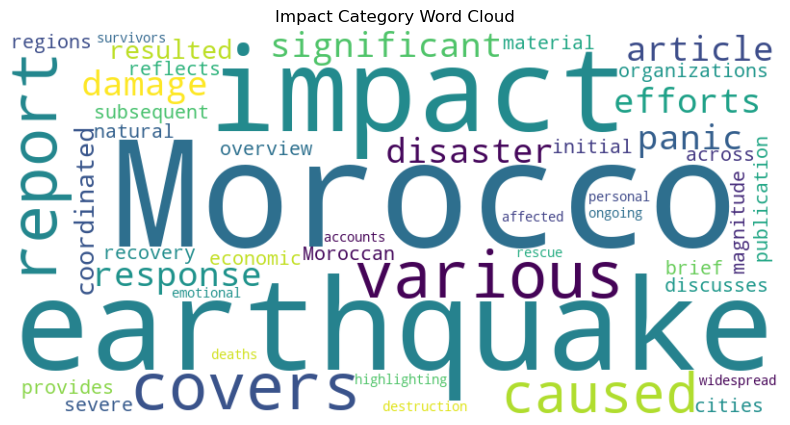

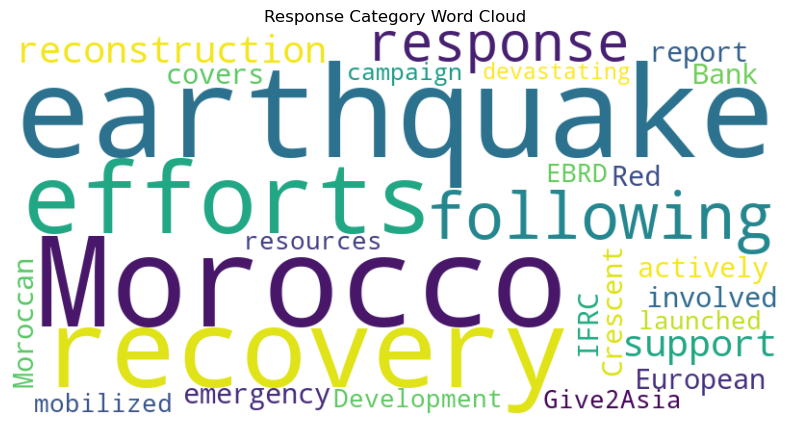

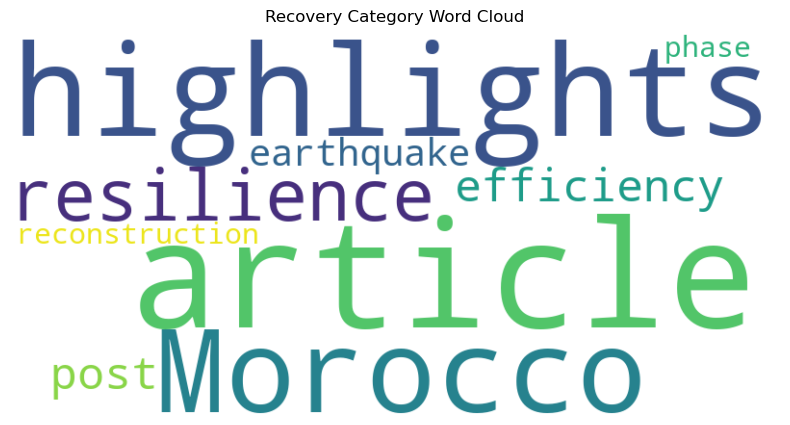

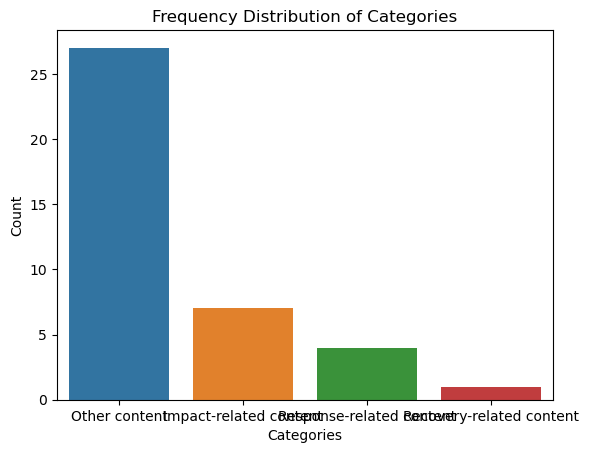

Classification Report:
               precision    recall  f1-score   support

      Impact       1.00      1.00      1.00         7
    Response       1.00      1.00      1.00         4
    Recovery       1.00      1.00      1.00         1
       Other       1.00      1.00      1.00        27

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



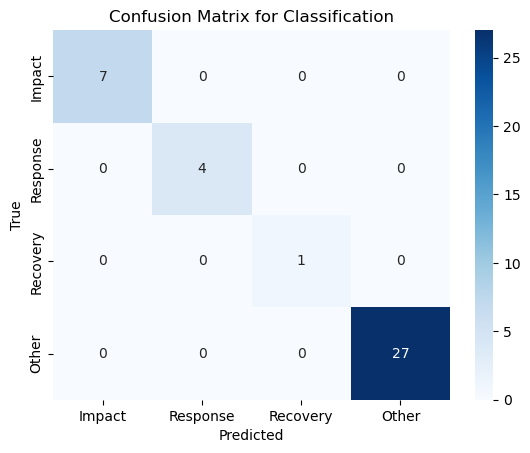

BLEU Score: {'bleu': 0.3533581360439615, 'precisions': [0.43193524650478293, 0.3712121212121212, 0.3317720530835285, 0.29307568438003223], 'brevity_penalty': 1.0, 'length_ratio': 1.9386590584878745, 'translation_length': 1359, 'reference_length': 701}
ROUGE Scores: {'rouge1': 0.6008550341568306, 'rouge2': 0.5565797560309332, 'rougeL': 0.597305481497263, 'rougeLsum': 0.5965756570685877}


In [18]:
# Required libraries
import json
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
import evaluate

# Load the dataset from JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Load T5 model for summarization
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Load RoBERTa model for NER (replace BERT with RoBERTa)
nlp_ner = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english", aggregation_strategy="simple")

# Define keywords for each category
impact_keywords = ['impact', 'damage', 'effect', 'devastation', 'destruction', 'casualties']
response_keywords = ['response', 'aid', 'help', 'assistance', 'support', 'relief']
recovery_keywords = ['recovery', 'rebuild', 'reconstruction', 'rehabilitation', 'restoration']

# Function to categorize sentences based on keywords
def assign_category(content):
    content = content.lower()
    if any(keyword in content for keyword in impact_keywords):
        return 'Impact'
    elif any(keyword in content for keyword in response_keywords):
        return 'Response'
    elif any(keyword in content for keyword in recovery_keywords):
        return 'Recovery'
    else:
        return 'Other'

# Function to summarize text using T5
def summarize_text(text):
    inputs = t5_tokenizer.encode(f"summarize: {text}", return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Initialize lists to store categorized texts and entities
impact_texts, response_texts, recovery_texts = [], [], []

# Perform classification and summarization
for index, row in df.iterrows():
    content = row['content']
    
    # Extract entities
    entities = nlp_ner(content)
    df.at[index, 'entities'] = str(entities)  # Store entities in DataFrame
    
    # Categorize the content
    label = assign_category(content)  # Use the assign_category function to classify based on keywords
    categories = {
        'Impact': 'Impact-related content',
        'Response': 'Response-related content',
        'Recovery': 'Recovery-related content',
        'Other': 'Other content'  # Default category for content that doesn't match any keywords
    }

    category = categories[label]  # Get the category label

    # Summarize the content
    summary = summarize_text(content)
    
    # Add content to the corresponding category list
    if category == "Impact-related content":
        impact_texts.append(content)
    elif category == "Response-related content":
        response_texts.append(content)
    elif category == "Recovery-related content":
        recovery_texts.append(content)
    
    # Store the results in the DataFrame
    df.at[index, 'category'] = category
    df.at[index, 'summary'] = summary

# Save the processed data to a new CSV file
df.to_csv('categorized_earthquake_data.csv', index=False)

# Function to generate word clouds
def generate_wordcloud(texts, title):
    if texts:
        text = " ".join(texts)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()

# Generate word clouds for impact, response, and recovery categories
generate_wordcloud(impact_texts, "Impact Category Word Cloud")
generate_wordcloud(response_texts, "Response Category Word Cloud")
generate_wordcloud(recovery_texts, "Recovery Category Word Cloud")

# Frequency distribution visualization
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Frequency Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

# Confusion matrix and classification report
# Map true labels, including 'Other content'
true_labels = df['category'].map({
    'Impact-related content': 0, 
    'Response-related content': 1, 
    'Recovery-related content': 2, 
    'Other content': 3
}).values

# Ensure predicted labels follow the same categorization
pred_labels = df['content'].apply(assign_category).map({
    'Impact': 0, 
    'Response': 1, 
    'Recovery': 2, 
    'Other': 3
}).values

# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Impact", "Response", "Recovery", "Other"]))

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Impact", "Response", "Recovery", "Other"], 
            yticklabels=["Impact", "Response", "Recovery", "Other"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classification")
plt.show()

# Summarization Evaluation (ROUGE and BLEU)
references = df['content'].tolist()
summaries = df['summary'].tolist()

# Adjust BLEU evaluation format
bleu_scores = evaluate.load('bleu').compute(
    predictions=summaries, 
    references=[[ref] for ref in references]
)
print("BLEU Score:", bleu_scores)

# Evaluate ROUGE scores
rouge_scores = evaluate.load('rouge').compute(predictions=summaries, references=references)
print("ROUGE Scores:", rouge_scores)
